In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [2]:
import albumentations as A
import numpy as np

from matplotlib import pyplot as plt
import torch
from torch.utils.data import ConcatDataset, DataLoader

from mermaidseg.datasets.dataset import MermaidDataset, CoralNetDataset, CoralscapesDataset
from mermaidseg.datasets.utils import _joint_collate
from mermaidseg.visualization import denormalize_image
from mermaidseg.datasets.concepts import labels_to_concepts
from mermaidseg.io import _load_csv_if_path

In [3]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA Device 0: Tesla T4


# 2. Data

## 2.1 Config

In [4]:
transform = A.Compose(
        [
            A.Resize(width=1024, height=1024, p=1),
            A.RandomCrop(width=512, height=512, p=1),
            A.HorizontalFlip(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )

In [11]:
batch_size = 4
# class_subset = [
#         "Macroalgae",
#         "Rubble",
#         "Sand",
#         "Porites",
#         "Crustose coralline algae",
#         "Bare substrate",
#         "Hard coral",
#         "Turf algae",
#         "Millepora",
#         "Tape",
#         "Soft coral",
#         "Acropora",
#         "Pocillopora",
#         "Porites lobata",
#         "Montipora",
#     ]
padding = 10
concept_mapping_flag = True

whitelist_sources = _load_csv_if_path("../../configs/run1_train_sources.csv")

## 2.2 Datasets

In [15]:
dataset_dict = {}
dataset_dict["mermaid"] = MermaidDataset(transform = transform, concept_mapping_flag=concept_mapping_flag, padding = padding)

dataset_dict["coralnet"] = CoralNetDataset(transform = transform, concept_mapping_flag=concept_mapping_flag, whitelist_sources=whitelist_sources, padding = padding)

dataset_dict["coralscapes"] = CoralscapesDataset(transform = transform, concept_mapping_flag=concept_mapping_flag)

Using custom data configuration EPFL-ECEO--coralscapes-c37b386a87ed6a16
Reusing dataset parquet (/home/sagemaker-user/.cache/huggingface/datasets/EPFL-ECEO___parquet/EPFL-ECEO--coralscapes-c37b386a87ed6a16/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/datasets/table.py:1318: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [16]:
for dataset_name, dataset in dataset_dict.items():
    print(f"Dataset: {dataset_name}, Length: {len(dataset)}, Classes: {dataset.num_classes}, Concepts: {dataset.num_concepts}")

Dataset: mermaid, Length: 8572, Classes: 186, Concepts: 226
Dataset: coralnet, Length: 89051, Classes: 246, Concepts: 293
Dataset: coralscapes, Length: 2075, Classes: 24, Concepts: 28


# 3. Dataset Exploration

## 3.1 MERMAID
The MERMAID Dataset can be used through the `MermaidDataset` class. This class reads the annotations from the `mermaid_confirmed_annotations.parquet` file found in the `coral reef training` S3 Bucket which can be found as the `df_annotations` attribute of the class, and from which the `df_images` attribute is also derived. The annotations of each image are done in a systematic approach, such that 25 points are taken in a 5x5 grid across the image (visualizations may not show this as currently a RandomCrop is used). From the annotations dataframe, which contains the label for a specific row & column in the image, we generate annotation masks which equal 0 (for background) and a class id for each annotated point (based on the id2label attribute).  

- We apply padding to the annotations, with the assumption that for a specific point (pixel being) assigned to a class, the neighbouring pixels are very likely to also be in that class as these labels come either from a image classification approach that makes a prediction based on a image crop around the point, or a manual annotation, both of which are most likely not precise to a pixel level.    
- As the `mermaid_confirmed_annotations.parquet` is continuously being updated, each run currently might have slightly different results due to changes in the (number of) images. As a solution to this, we can potentially save occasional copies of the file (e.g. at the end of every month). 

In [9]:
print("Images", dataset_dict["mermaid"].df_images.shape)
display(dataset_dict["mermaid"].df_images.head())
print("Annotations", dataset_dict["mermaid"].df_annotations.shape)
display(dataset_dict["mermaid"].df_annotations.head())

Images (8529, 3)


,image_id,region_id,region_name
0,00059a47-03b8-47f3-adf6-3ab5616922cf,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
1,00086e76-2b0d-48ff-a25b-31020c226047,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
2,00138e67-611c-4e04-a382-46e0484f2f95,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
3,0015772a-fcc3-4bd8-bfb8-2a3b67520f35,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
4,001580fa-3324-4053-a74b-c5ef08d49d07,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific


Annotations (186599, 12)


,id,image_id,point_id,row,col,benthic_attribute_id,benthic_attribute_name,growth_form_id,growth_form_name,updated_on,region_id,region_name
0,adf9f72c-f498-454b-b4c2-d3cb6a2d1c5f,00059a47-03b8-47f3-adf6-3ab5616922cf,44044125-e1b8-4580-8531-acaf18a66935,457,467,30a987e9-b420-4db6-a83a-a1f7cabd14fb,Soft coral,None,None,2025-08-26 14:55:15.009823+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
1,0e97b960-cc38-49ed-91c6-f760f1eff354,00059a47-03b8-47f3-adf6-3ab5616922cf,e8c950a2-c37f-4f5e-8797-3f2d244257b6,457,934,b76bca12-884b-4404-bb9f-97d505b0fe58,Sand,None,None,2025-08-26 14:55:15.039272+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
2,1823ca56-edac-459e-b009-46c390f64afe,00059a47-03b8-47f3-adf6-3ab5616922cf,766bd109-c9f7-4489-8215-f2a46ffd9419,457,1401,d9086647-3a82-4634-97bc-6e10347af39b,Bare substrate,None,None,2025-08-26 14:55:15.085659+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
3,dc9d3b2d-b9f9-4a46-a208-790b5c3b2ec3,00059a47-03b8-47f3-adf6-3ab5616922cf,6aaaea05-f005-4e3e-a9bf-d6702e0b7736,457,1868,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,2025-08-26 14:55:15.133907+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
4,9bde5850-bb38-4ca3-88b3-43799f53f0ea,00059a47-03b8-47f3-adf6-3ab5616922cf,bed04244-e299-4eec-b9b7-05e15dbf5a75,457,2335,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,2025-08-26 14:55:15.181096+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific


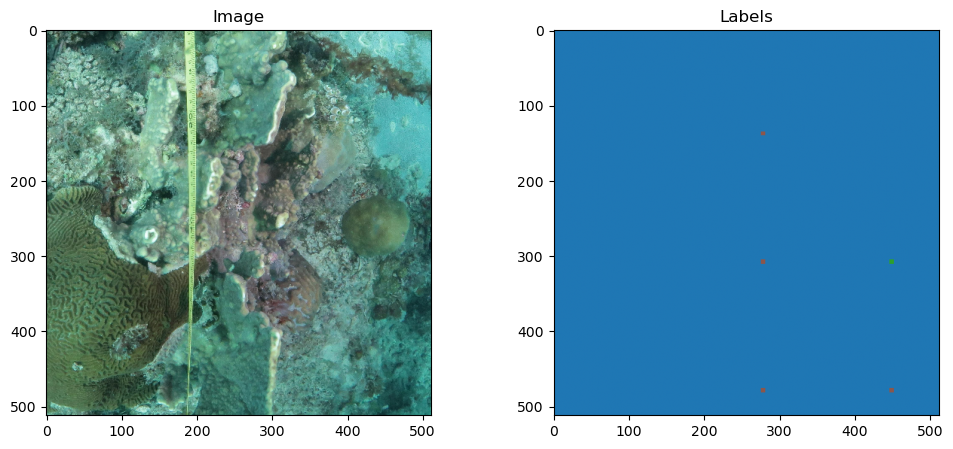

In [10]:
image, labels = dataset_dict["mermaid"][15]

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(denormalize_image(image).transpose(1,2,0))
ax[0].set_title("Image")
ax[1].imshow(labels, cmap='tab10', vmin=0, vmax=dataset_dict["mermaid"].num_classes)
ax[1].set_title("Labels")
plt.show()

## 3.2 CoralNet
The CoralNet Dataset can be used through the `CoralNetDataset` class. This class reads the annotations from the `coralnet_annotations_30112025.parquet` file found in the `dev-datamermaid-sm-sources` S3 Bucket which can be found as the `df_annotations` attribute of the class, and from which the `df_images` attribute is also derived. Unlike the systematic annotation of MERMAID, annotations in CoralNet are usually acquired through random sampling or just human labels across the image (which result in random annotations). From the annotations dataframe, which contains the label for a specific row & column in the image, we generate annotation masks which equal 0 (for background) and a class id for each annotated point (based on the id2label attribute). The CoralNet classes are mapped to MERMAID classes using the LabelMapping API endpoint. 

- We apply padding to the annotations, with the assumption that for a specific point (pixel being) assigned to a class, the neighbouring pixels are very likely to also be in that class as these labels come either from a image classification approach that makes a prediction based on a image crop around the point, or a manual annotation, both of which are most likely not precise to a pixel level.    
- The parquet file currently only contains a subset of the sources in order to speed up data loading, and can be updated using the mermaidseg/nbs/datasets/CoralNet_Annotations.ipynb notebook. 

In [17]:
print("Images", dataset_dict["coralnet"].df_images.shape)
display(dataset_dict["coralnet"].df_images.head())
print("Annotations", dataset_dict["coralnet"].df_annotations.shape)
display(dataset_dict["coralnet"].df_annotations.head())

Images (89051, 2)


,source_id,image_id
0,23,12805
1,23,12806
2,23,12807
3,23,12808
4,23,12809


Annotations (3846529, 5)


,source_id,image_id,row,col,benthic_attribute_name
0,23,12805,735,1008,None
1,23,12805,663,1682,Sand
2,23,12805,955,1737,Sand
3,23,12805,1034,1431,Dead coral
4,23,12805,851,2036,Sand


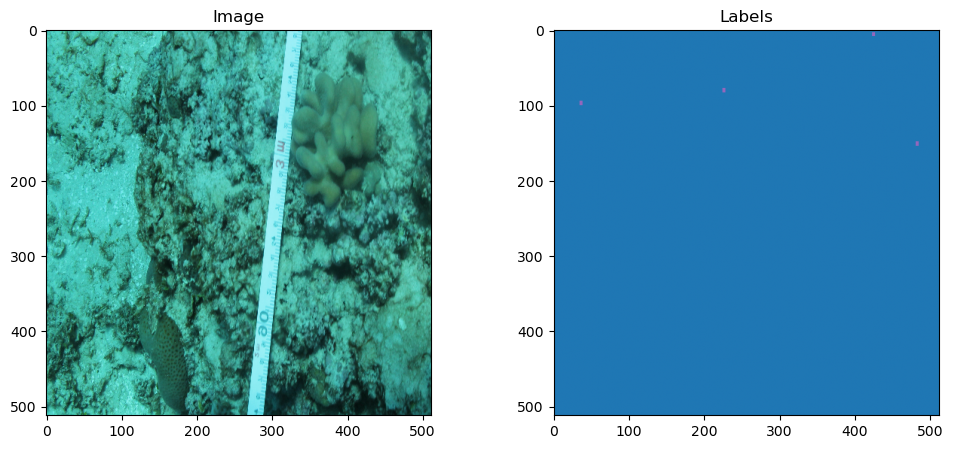

In [12]:
image, labels = dataset_dict["coralnet"][5000]

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(denormalize_image(image).transpose(1,2,0))
ax[0].set_title("Image")
ax[1].imshow(labels, cmap='tab10', vmin=1, vmax=dataset_dict["coralnet"].num_classes)
ax[1].set_title("Labels")
plt.show()

## 3.3 CoralScapes
The CoralScapes Dataset can be used through the `CoralscapesDataset` class. This class loads the dataset from the HuggingFace version of Coralscapes dataset The annotations within Coralscapes are done at a pixel-level, with masks covering the entire image. Therefore even though the dataset contains a small number of images compared to the other two datasets, the number of annotated pixels are at a similar scale, and training on Coralscapes might improve the model's segmentation abilities. The Coralscapes classes are mapped to MERMAID classes using coralscapes_39_to_mermaid dictionary defined within the class. 

- The current version of Coralscapes implemented is a v1, and a v2 of the same dataset with higher resolution classes, more data and polygons will be implemented soon. 

In [18]:
print("Images", len(dataset_dict["coralscapes"]))

Images 2075


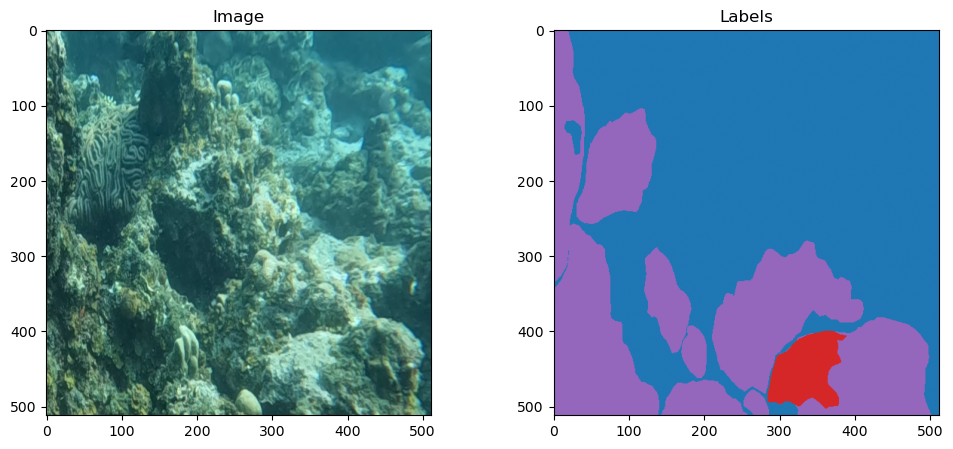

In [13]:
image, labels = dataset_dict["coralscapes"][0]

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(denormalize_image(image).transpose(1,2,0))
ax[0].set_title("Image")
ax[1].imshow(labels, cmap='tab10', vmin=1, vmax=dataset_dict["coralscapes"].num_classes)
ax[1].set_title("Labels")
plt.show()

# 4 Concept Exploration

In [31]:
dataset_dict["coralscapes"].benthic_concept_matrix

concept,Acropora,Acroporidae,Bare substrate,Crustose coralline algae,Hard coral,Macroalgae,Millepora,Milleporidae,Montipora,Other,Pocillopora,Pocilloporidae,Porites,Porites lobata,Poritidae,Rubble,Sand,Soft coral,Tape,Turf algae
level,2,1,0,0,0,0,2,1,2,0,2,1,2,3,1,0,0,0,1,0
Macroalgae,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Rubble,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Sand,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Porites,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
Crustose coralline algae,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bare substrate,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hard coral,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Turf algae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Millepora,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


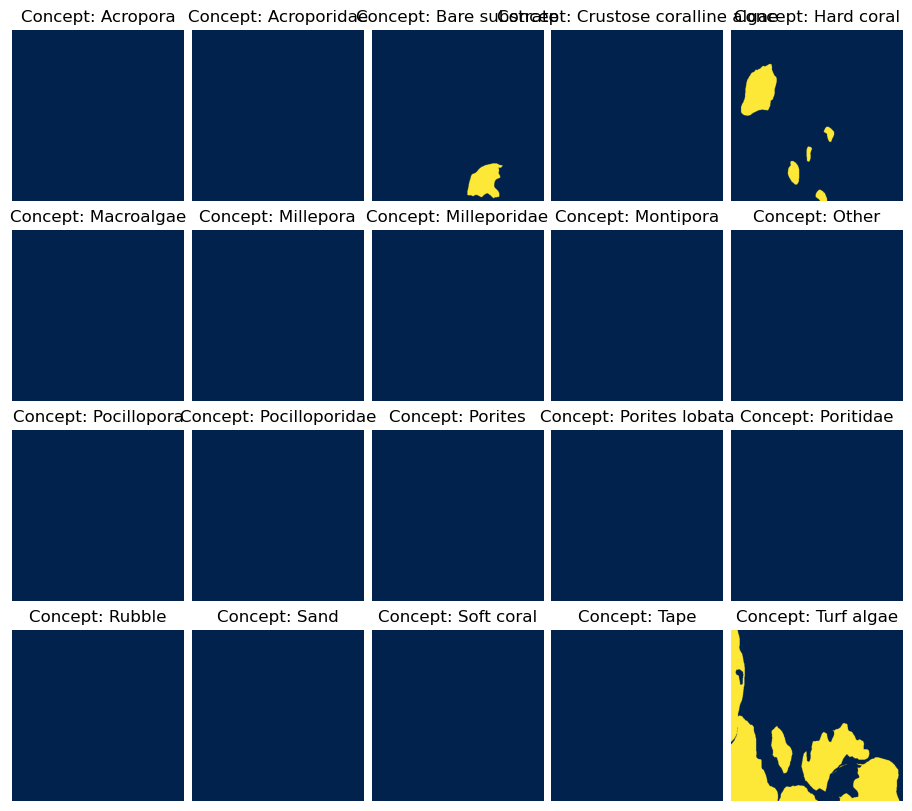

In [30]:
concept_labels = labels_to_concepts(labels[None], dataset_dict["coralscapes"].benthic_concept_matrix)

fig, ax = plt.subplots(4,5, figsize=(10,8), layout = "compressed")
ax = ax.flatten()

for i in range(concept_labels.shape[1]):
    ax[i].set_title(f"Concept: {dataset_dict['coralscapes'].id2concept[i+1]}")
    ax[i].imshow(concept_labels[0,i], vmin = 0, vmax =1, cmap = "cividis")
    ax[i].set_axis_off()
plt.show()

# 5. DataLoader

In [13]:
dataloader = DataLoader(ConcatDataset(list(dataset_dict.values())), batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, collate_fn=_joint_collate)

In [14]:
len(dataloader)

23966

In [15]:
data = next(iter(dataloader))

/opt/conda/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [16]:
len(data), data[0].shape, data[1].shape

(2, torch.Size([4, 3, 512, 512]), torch.Size([4, 512, 512]))